In [2]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

580


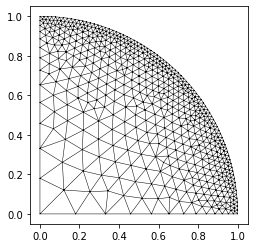

In [3]:
# we define the mesh
r = 1
cell_size = 0.02

import pygmsh
with pygmsh.geo.Geometry() as geom:
    center = geom.add_point([0, 0], 10*cell_size)
    lower_right = geom.add_point([0, r], cell_size)
    upper_left = geom.add_point([r, 0], cell_size)

    bottom = geom.add_line(center, lower_right)
    left = geom.add_line(upper_left, center)
    arc = geom.add_circle_arc(lower_right, center, upper_left)

    loop = geom.add_curve_loop([bottom, arc, left])
    surface = geom.add_plane_surface(loop)
    out = geom.generate_mesh()

mesh = Mesher.Mesh(out, simultype='axis')
mesh.plot()
print(mesh.nn)

In [4]:
# geomechanical parameters
k = 8.4e3  # elastic drained bulk modulus [MPa]
g = 6.8e3  # shear modulus [MPa]
b = 0.707692  # biot coefficient
M = 9.18478e3  # biot modulus [MPa]
k_u = k + M*b**2
perm = 0.137549e-3  # permeability
B = (k_u - k) / (b * k_u)
mu_f = 1  # fluid viscosity
rho = 1  # density
kappa = perm / mu_f  # conductivity
nu_u = prop.poisson_ratio(g, k_u)  # undrained poisson ratio
E_u = prop.young_modulus(g, k_u)  # undrained yougn modulus
nu = prop.poisson_ratio(g, k)  # poisson ratio
E = prop.young_modulus(g, k)  # young modulus
eta = b * (1 - 2 * nu_u) / (2 * (1 - nu_u))  # idk what this is

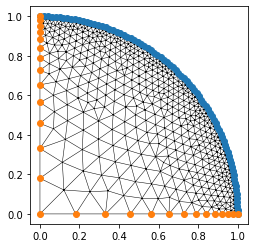

In [5]:
# boundary conditions
bottom = np.argwhere(mesh.nodes[:, 1] == 0)
left = np.argwhere(mesh.nodes[:, 0] < 1e-3)

fixed_dofx = left * 2
fixed_dofy = bottom * 2 + 1

fixed_nodes = np.unique((left, bottom))
fixed_dof = np.unique((fixed_dofx, fixed_dofy))

radius = np.linalg.norm(mesh.nodes, axis=1)
circle = np.argwhere(np.abs(radius - r) <= 1e-3)

mesh.plot()
plt.scatter(*mesh.nodes[circle].T, zorder=10)
plt.scatter(*mesh.nodes[fixed_nodes].T, zorder=10)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x281d0fb92b0>)

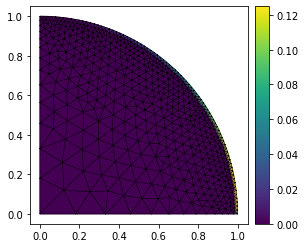

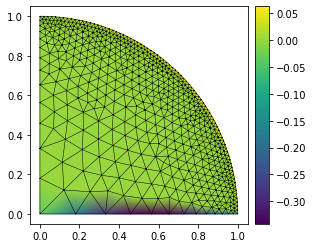

In [6]:
# initial stress field
sig_unif = [-1, -1, 0, -1]
sigma0 = Matrix.set_stress_field(mesh, sig_unif)

s0 = sigma0.reshape(2, -1, order='F')
mesh.plot(s0[0])
mesh.plot(s0[1])

In [7]:
# assembling the different matrices
K = Matrix.assemble_stiffness_matrix(mesh, E, nu)
Mass = Matrix.assemble_mass_matrix(mesh, 1/M)
C = Matrix.assemble_conductivity_matrix(mesh, kappa)
Ce = Matrix.assemble_coupling_matrix(mesh, b)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [8]:
# we can now solve the undrained case
dt = 0
AA = -Mass - dt *C

ntot_E = mesh.nn * 2
ntot_P = mesh.nn
ntot = ntot_E + ntot_P

T = csc_matrix((ntot, ntot))
T[:ntot_E, :ntot_E] = K
T[ntot_E:, :ntot_E] = -Ce.T
T[:ntot_E, ntot_E:] = -Ce
T[ntot_E:, ntot_E:] = AA

ftot = csc_matrix((ntot, 1))
ftot[:ntot_E] = sigma0

eq_free_disp = np.setdiff1d(np.arange(ntot_E), fixed_dof)
eq_free_p = np.arange(ntot_P) + ntot_E
eq_free = np.hstack((eq_free_disp, eq_free_p))


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
# solving the system
undrained_sol = csc_matrix((ntot, 1))
undrained_sol[eq_free] = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])

pressure_undrained = undrained_sol[ntot_E:].toarray()[:, 0]
disp_undrained = undrained_sol[:ntot_E].toarray().reshape(2, -1, order='F')

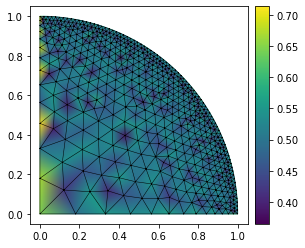

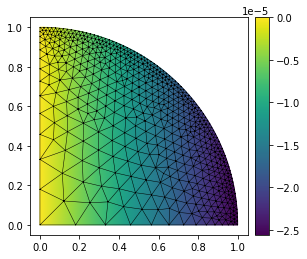

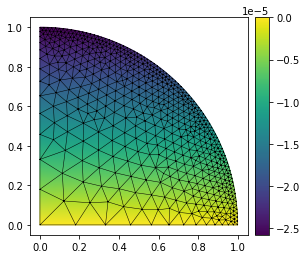

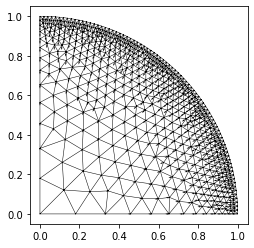

In [10]:
mesh.plot(pressure_undrained)
mesh.plot(disp_undrained[0])
mesh.plot(disp_undrained[1])
fig, ax = mesh.plot()
ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], disp_undrained[0], disp_undrained[1])

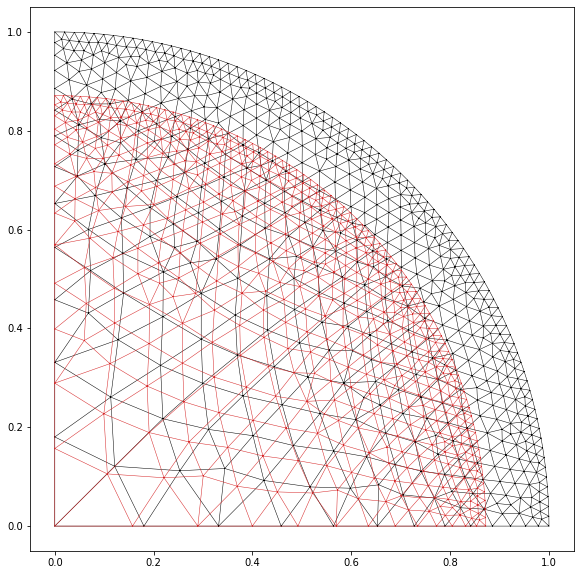

In [11]:
factor = 5e3
plt.triplot(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.connectivity, c='k', lw=0.5)
plt.triplot(mesh.nodes[:, 0] + factor*disp_undrained[0], mesh.nodes[:, 1] + factor*disp_undrained[1], 
            mesh.connectivity, c='tab:red', lw=0.5, alpha=1)
plt.gcf().set_size_inches(10, 10)

plt.gca().set_aspect(1)

In [12]:
dt = 0.002
t = np.arange(0, 1, dt)

T[ntot_E:, ntot_E:] = -(Mass + dt * C)
pressure = np.zeros((len(t), mesh.nn))
displacement = np.zeros((len(t), 2, mesh.nn))

sol = undrained_sol.copy().toarray()[:, 0]
sol[circle + ntot_E] = 0

eq_free_disp = np.setdiff1d(np.arange(ntot_E), fixed_dof)
eq_free_p = np.setdiff1d(np.arange(ntot_P), circle) + ntot_E
eq_free = np.hstack((eq_free_disp, eq_free_p))


p = np.zeros(ntot)
for i in range(len(t)):
    print(f'\riteration {i+1} out of {len(t)}', end='')

    # the change in flux is adjusted
    p[eq_free_p] = dt * C[eq_free_p - ntot_E].dot(sol[ntot_E:])

    # we can solve the system
    update = linalg.spsolve(T[eq_free][:, eq_free], p[eq_free])
    sol[eq_free] = sol[eq_free] + update

    pressure[i] = sol[ntot_E:]
    displacement[i] = sol[:ntot_E].reshape(2, -1, order='F')

iteration 500 out of 500

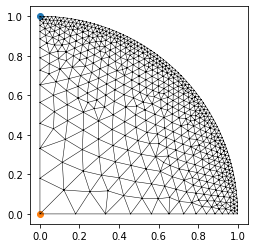

In [13]:
top = np.argwhere((mesh.nodes[:, 0] <= 1e-3) & (np.abs(mesh.nodes[:, 1] - r) <= 1e-3))[:, 0]
bottom = np.argwhere((mesh.nodes[:, 1] <= 1e-3) & (np.abs(mesh.nodes[:, 0] - r) <= 1e-3))[:, 0]
center = np.argwhere((mesh.nodes[:, 0] <= 1e-3) & (mesh.nodes[:, 1] <= 1e-3))[:, 0]

mesh.plot()
plt.scatter(*mesh.nodes[top].T)
plt.scatter(*mesh.nodes[center].T)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x281d0c82220>)

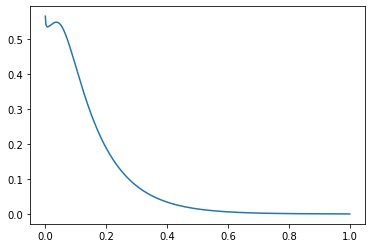

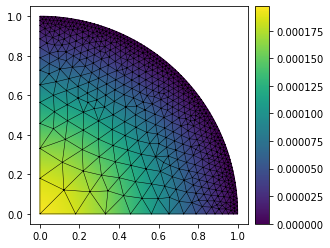

In [14]:
pressure[:, top].shape
plt.plot(t, pressure[:, center])
mesh.plot(pressure[-1])


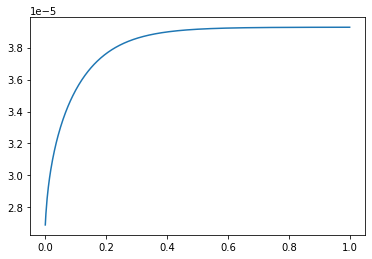

In [15]:
norm = np.linalg.norm(displacement, axis=1)
plt.plot(t, norm[:, top])